## (0.1) Import libraries

In [1]:
## Dependencies

import pandas as pd
import pathlib as path

import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt
import hvplot.pandas
import geopandas as gpd

import requests
import json
from pprint import pprint


## (0.2) define function for regression

In [2]:
def regression_plot(dataframe, col1, col2):

    x_axis = dataframe[col1]
    y_axis = dataframe[col2]

    ## calculate slope and intercept of the regression equation

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    
    #print the r-value

    print(f' The r^value is : {round(rvalue,3)}')

    ### generate the equation to be used as annotation
    
    regress_values = x_axis * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    ## generate the regression line plot 

    plt.scatter(x_axis,y_axis)
    plt.plot(x_axis,regress_values,"r-")

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} vs {col2}')

    ## Conditional Annotation position

    if slope >= 0 :
        x_annot_pos = 0.05
        y_annot_pos = 0.9
    else : x_annot_pos, y_annot_pos = 0.05, 0.1

    plt.annotate(line_eq,(x_annot_pos,y_annot_pos), fontsize=12,color="red", xycoords='axes fraction')

    plt.savefig(f'Output/Q4_regression_{col1}_vs_{col2}.png')
    plt.show()

# 1) COLLECT THE DATA

## (1.1) Countries referential
Extract the official referential of Countries used by the World Bank
- OUtput : file CSV availabe in directory Resources
- source : API World Bank
        ### this code should / must be runned once (no need to update the file)
        ## will be used below to extract data (Regions + population)
        ## can be used for different other requests

In [4]:
## retrieve all the countries in API

### generate DF Countries

page = 1   ## there are 6 pages in the json file
data = []
url_countries = 'https://api.worldbank.org/v2/country?format=json'

for page in range(1,7):
    response = requests.get(f"{url_countries}&page={page}")
    json_data = response.json()
    
    # Add the data from the current page
    data.extend(json_data[1])  
    
## create DF and select columns

countries_df = pd.DataFrame(data)
countries_df['region'] = countries_df['region'].apply(lambda x: x['value'])
countries_df = countries_df[['id', 'iso2Code', 'name', 'region','capitalCity', 'longitude', 'latitude']]

### Export to csv file

country_path = 'Output/output_countries_list_UN_referential.csv'
countries_df.to_csv(country_path)

countries_df.head()

,id,iso2Code,name,region,capitalCity,longitude,latitude
0,ABW,AW,Aruba,Latin America & Caribbean,Oranjestad,-70.0167,12.5167
1,AFE,ZH,Africa Eastern and Southern,Aggregates,,,
2,AFG,AF,Afghanistan,South Asia,Kabul,69.1761,34.5228
3,AFR,A9,Africa,Aggregates,,,
4,AFW,ZI,Africa Western and Central,Aggregates,,,


## 1.2) Collect Data for COVID deaths 
    Daily data from 2020 to 2024
    Resource : CSV file from World Health Organization : https://data.who.int/dashboards/covid19/data?n=o

In [6]:
## create DataFrame death statistics
### import and read csv file

path_deaths = 'Resources/WHO-COVID-19-global-daily-data.csv'
deaths_df = pd.read_csv(path_deaths)

deaths_df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,AI,Anguilla,AMR,NaN,0,NaN,0
1,2020-01-04,AZ,Azerbaijan,EUR,NaN,0,NaN,0
2,2020-01-04,BB,Barbados,AMR,NaN,0,NaN,0
3,2020-01-04,BR,Brazil,AMR,NaN,0,NaN,0
4,2020-01-04,BD,Bangladesh,SEAR,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...
413755,2024-09-22,BB,Barbados,AMR,NaN,108815,NaN,593
413756,2024-09-22,BR,Brazil,AMR,NaN,37511921,NaN,702116
413757,2024-09-22,AZ,Azerbaijan,EUR,NaN,836285,NaN,10353
413758,2024-09-22,CO,Colombia,AMR,NaN,6394022,NaN,142727


## 1.3) Collect Data for COVID vaccination compaign
data by country and per day of vaccination compaign

In [31]:
## create DataFrame Vaccination 

## Import and read csv file

path_Vaccination = 'Resources/vaccinations._daily.csv'
Vaccination_df = pd.read_csv(path_Vaccination)

# Vaccination _df exploration

print(Vaccination_df.shape)
print(Vaccination_df.dtypes)
print(Vaccination_df.head())

(196246, 16)
location                                object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
total_boosters                         float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
total_boosters_per_hundred             float64
daily_vaccinations_per_million         float64
daily_people_vaccinated                float64
daily_people_vaccinated_per_hundred    float64
dtype: object
      location iso_code        date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG  2021-02-22                 0.0                0.0   
1  Afghanistan      AFG  2021-02-23                 NaN          

In [ ]:
# ### select columns
# Vaccination_df = Vaccination_df[['location','iso_code','date','daily_people_vaccinated']]
# Vaccination_df = Vaccination_df.rename(columns={'location':'country','iso_code':'id'})
# Vaccination_df

## 1.4) Collect total Population for each country
        API World Bank : https://api.worldbank.org/v2/country/{COUNTRY}/indicator/{INDICATOR}?date={Time Periode}&format=json


In [8]:
print(f"start code")
print('---------------------------')

## create list of countries from previous DF

country_list = countries_df['id'].tolist()

# gdp_list = []
pop_list = []

# indicator = ['NY.GDP.PCAP.CD','SP.POP.TOT']

# each country has its onwn end Point, so need to loop through all end points and extract needed data

for id in country_list :

    print(f"--------------------------")
    print(f"country {id}")

    ## collect data for Population

    try:

        link_pop = f'https://api.worldbank.org/v2/country/{id}/indicator/SP.POP.TOTL?date=2019:2023&format=json'
        response_pop = requests.get(link_pop).json()

        # pprint(response_pop)

        pop_list.append({
            'country_ID' : response_pop[1][0]['countryiso3code'],
            'country_ID_2' : response_pop[1][0]['country']['id'],
            'country_name' : response_pop[1][0]['country']['value'],              
            'pop_2023' : response_pop[1][0]['value'] ,
            'pop_2022' :response_pop[1][1]['value'] ,
            'pop_2021' :response_pop[1][2]['value'] ,
            'pop_2020' : response_pop[1][3]['value'],
            'pop_2019' : response_pop[1][4]['value']
            })
    except:   
        print("Country not found POP. Skipping...")


    ## collect data for GDP

    # try:  
    #     link_gdp = f'https://api.worldbank.org/v2/country/{id}/indicator/NY.GDP.PCAP.CD?date=2019:2023&format=json'
    #     response_gdp = requests.get(link_gdp).json()

    #     # pprint(response_gdp)

    #     gdp_list.append({
    #         'country_ID' : response_gdp[1][0]['countryiso3code'],
    #         'country_ID_2' : response_gdp[1][0]['country']['id'],
    #         'country_name' : response_gdp[1][0]['country']['value'],
    #         'GDPcap_2023' : response_gdp[1][0]['value'] ,
    #         'GDPcap_2022' : response_gdp[1][1]['value'] ,
    #         'GDPcap_2021' : response_gdp[1][2]['value'] ,
    #         'GDPcap_2020' : response_gdp[1][3]['value'],
    #         'GDPcap_2019' : response_gdp[1][4]['value']
    #         })
        

    # except: 
    #     print("Country not found GDP. Skipping...")



start code
---------------------------
--------------------------
country ABW
--------------------------
country AFE
--------------------------
country AFG
--------------------------
country AFR
Country not found POP. Skipping...
--------------------------
country AFW
--------------------------
country AGO
--------------------------
country ALB
--------------------------
country AND
--------------------------
country ARB
--------------------------
country ARE
--------------------------
country ARG
--------------------------
country ARM
--------------------------
country ASM
--------------------------
country ATG
--------------------------
country AUS
--------------------------
country AUT
--------------------------
country AZE
--------------------------
country BDI
--------------------------
country BEA
Country not found POP. Skipping...
--------------------------
country BEC
Country not found POP. Skipping...
--------------------------
country BEL
--------------------------
country BE

In [9]:
## Create DF

# gdp_df = pd.DataFrame(gdp_list)

pop_df = pd.DataFrame(pop_list)
pop_df = pop_df.dropna(how='all')

pop_df.head()

,country_ID,country_ID_2,country_name,pop_2023,pop_2022,pop_2021,pop_2020,pop_2019
0,ABW,AW,Aruba,106277.0,106445.0,106537.0,106585.0,106442.0
1,AFE,ZH,Africa Eastern and Southern,739108306.0,720859132.0,702977106.0,685112979.0,667242986.0
2,AFG,AF,Afghanistan,42239854.0,41128771.0,40099462.0,38972230.0,37769499.0
3,AFW,ZI,Africa Western and Central,502789511.0,490330870.0,478185907.0,466189102.0,454306063.0
4,AGO,AO,Angola,36684202.0,35588987.0,34503774.0,33428486.0,32353588.0


# 2) PROCESS THE DATA
cleaning and tranformation

## 2.1) deaths data cleaning

In [10]:
# exploration death_df 

print(deaths_df.shape)
print(deaths_df.dtypes)

(413760, 8)
Date_reported         object
Country_code          object
Country               object
WHO_region            object
New_cases            float64
Cumulative_cases       int64
New_deaths           float64
Cumulative_deaths      int64
dtype: object


In [11]:
### change data type for columns INT + date

deaths_df = deaths_df.astype({
                            'Date_reported' : 'datetime64[ns]',
                            'New_cases': "Float64", 
                            'Cumulative_cases': "Float64", 
                            'Cumulative_deaths' : 'Float64'
                            })

### add columns Year + Month
deaths_df['year'] = deaths_df['Date_reported'].dt.year
deaths_df['month'] = deaths_df['Date_reported'].dt.month

### Rename col
deaths_df = deaths_df.rename(columns={'Date_reported' : 'date',
                                      'Country':'country',
                                      'Country_code':'id',
                                      'Cumulative_deaths':'total_deaths'
                                      })

### select columns
deaths_df = deaths_df.drop(columns={'New_cases','Cumulative_cases'})

deaths_df.dtypes

date            datetime64[ns]
id                      object
country                 object
WHO_region              object
New_deaths             float64
total_deaths           Float64
year                     int32
month                    int32
dtype: object

In [12]:
deaths_df.head()

,date,id,country,WHO_region,New_deaths,total_deaths,year,month
0,2020-01-04,AI,Anguilla,AMR,NaN,0.0,2020,1
1,2020-01-04,AZ,Azerbaijan,EUR,NaN,0.0,2020,1
2,2020-01-04,BB,Barbados,AMR,NaN,0.0,2020,1
3,2020-01-04,BR,Brazil,AMR,NaN,0.0,2020,1
4,2020-01-04,BD,Bangladesh,SEAR,0.0,0.0,2020,1


### 2.2 Deaths by country
cleaning + transformation

In [13]:
### count of total deaths by country GRoupBy

deaths_country_df = deaths_df.groupby('country').agg({
                                                'total_deaths' : 'max'})

deaths_country_df = deaths_country_df.reset_index()
deaths_country_df 
# death_total_country.sort_values(ascending=False)

,country,total_deaths
0,Afghanistan,7998.0
1,Albania,3605.0
2,Algeria,6881.0
3,American Samoa,34.0
4,Andorra,159.0
...,...,...
235,Wallis and Futuna Is,9.0
236,West Bank and Gaza Strip,5708.0
237,Yemen,2159.0
238,Zambia,4078.0


### 2.3 Deaths Daily evolution
cleaning + transformation


In [14]:
## create DF for daily evolution

deaths_daily_df = deaths_df[['date','New_deaths']].groupby(['date']).sum('New_deaths')
deaths_daily_df = deaths_daily_df.reset_index()
deaths_daily_df

,date,New_deaths
0,2020-01-04,0.0
1,2020-01-05,3.0
2,2020-01-06,0.0
3,2020-01-07,0.0
4,2020-01-08,0.0
...,...,...
1719,2024-09-18,0.0
1720,2024-09-19,0.0
1721,2024-09-20,0.0
1722,2024-09-21,1.0


### 2.3.1) daily deaths : remove outliers
IQR method

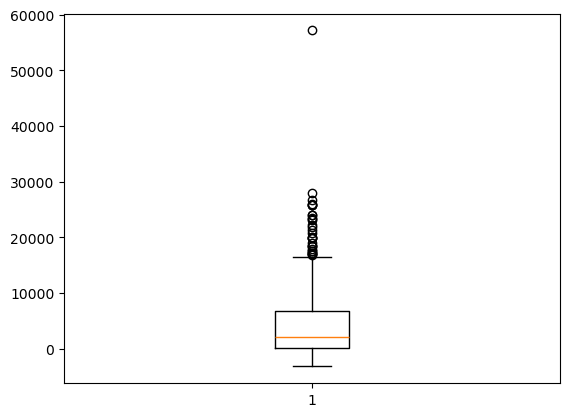

In [15]:
### identify outliers

plt.boxplot(deaths_daily_df['New_deaths'])
plt.show()

In [16]:
### Identify outliers ; IQR method

var = deaths_daily_df['New_deaths']
q1 = np.quantile(var, 0.25) 
q3 = np.quantile(var, 0.75)   
iqr = q3 - q1
outliers = var[(var > (q3 + (iqr * 1.5))) | (var < (q1 - (iqr * 1.5)))].tolist()

print(f'Q1= {q1}')
print(f'Q3= {q3}')
print(f'iqr= {iqr}')
print(outliers)


Q1= 207.0
Q3= 6756.75
iqr= 6549.75
[17152.0, 17072.0, 18955.0, 21321.0, 23940.0, 23070.0, 24027.0, 25785.0, 25889.0, 22194.0, 23455.0, 25951.0, 26732.0, 27939.0, 25898.0, 23250.0, 21839.0, 16928.0, 17118.0, 17976.0, 19955.0, 20068.0, 20797.0, 19884.0, 18437.0, 19923.0, 17572.0, 17569.0, 18447.0, 18421.0, 17109.0, 57167.0]


In [17]:
### remove outliers

deaths_daily_clean_df = deaths_daily_df[~deaths_daily_df['New_deaths'].isin(outliers)]
deaths_daily_clean_df

,date,New_deaths
0,2020-01-04,0.0
1,2020-01-05,3.0
2,2020-01-06,0.0
3,2020-01-07,0.0
4,2020-01-08,0.0
...,...,...
1719,2024-09-18,0.0
1720,2024-09-19,0.0
1721,2024-09-20,0.0
1722,2024-09-21,1.0


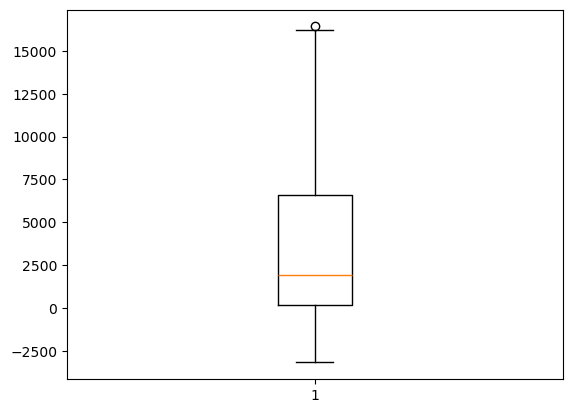

In [18]:
###last check

plt.boxplot(deaths_daily_clean_df['New_deaths'])
plt.show()

### 2.3.1) daily deaths : calculate a moving average

In [19]:
## Calculate a moving average

## define number of days 
x_days=7 

## calculate + create a list + add to a new columns

deaths_smooth_list= []

for i in range((x_days), (len(deaths_daily_clean_df))):

    daily_smooth = deaths_daily_clean_df['New_deaths'].iloc[(i-x_days):i].mean()
    deaths_smooth_list.append(daily_smooth)

# Insert the first day manually (since there's no previous day for the first value)
for j in range(0,x_days) :
    deaths_smooth_list.insert((j), deaths_smooth_list[0])



# Add the daily flow to the DataFrame
deaths_daily_clean_df['daily_deaths_smooth'] = deaths_smooth_list

# death_daily_clean_df.to_csv('Output/test4.csv')
deaths_daily_clean_df

C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\978539372.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_daily_clean_df['daily_deaths_smooth'] = deaths_smooth_list


,date,New_deaths,daily_deaths_smooth
0,2020-01-04,0.0,0.428571
1,2020-01-05,3.0,0.428571
2,2020-01-06,0.0,0.428571
3,2020-01-07,0.0,0.428571
4,2020-01-08,0.0,0.428571
...,...,...,...
1719,2024-09-18,0.0,132.428571
1720,2024-09-19,0.0,132.428571
1721,2024-09-20,0.0,132.428571
1722,2024-09-21,1.0,132.428571


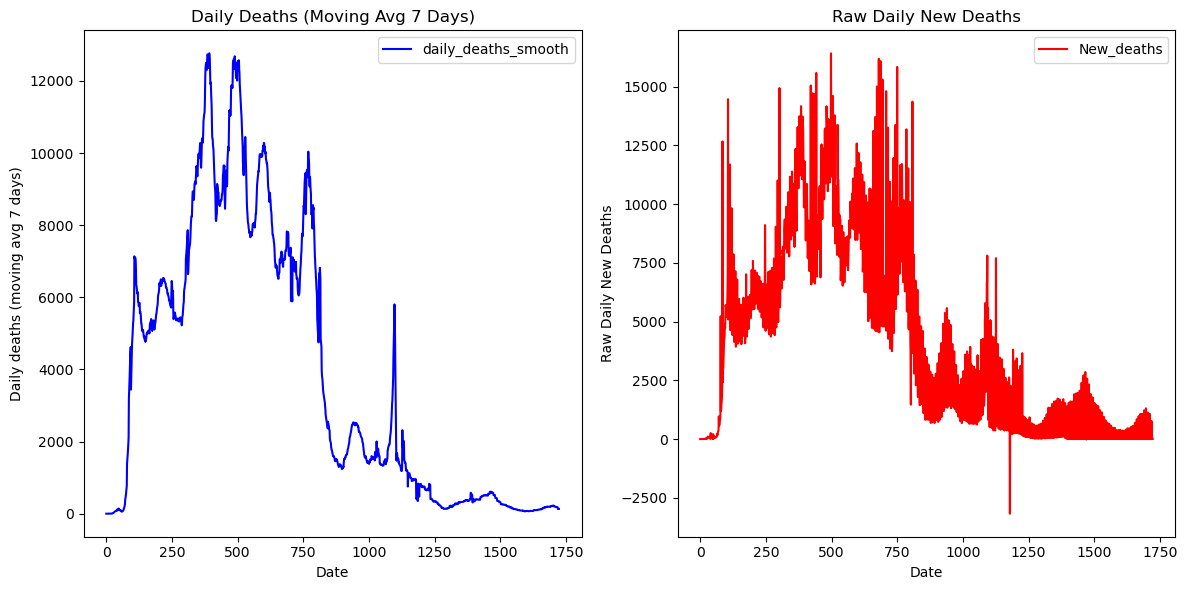

In [24]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot - Smoothed daily deaths (7-day moving average)
deaths_daily_clean_df.plot(kind='line', y="daily_deaths_smooth", ax=ax1, color='blue')
ax1.set_title('Daily Deaths (Moving Avg 7 Days)')
ax1.set_ylabel('Daily deaths (moving avg 7 days)')
ax1.set_xlabel('Date')

# Second subplot - Raw new deaths
deaths_daily_clean_df.plot(kind='line', y="New_deaths", ax=ax2, color='red')
ax2.set_title('Raw Daily New Deaths')
ax2.set_ylabel('Raw Daily New Deaths')
ax2.set_xlabel('Date')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## 2.4) cleaning and transform :  Vaccination Data

In [32]:
Vaccination_df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,33.0,1367.0,0.003


In [33]:
### select columns
Vaccination_df = Vaccination_df[['location','iso_code','date','daily_people_vaccinated']]
Vaccination_df = Vaccination_df.rename(columns={'location':'country','iso_code':'id'})
Vaccination_df.head()

,country,id,date,daily_people_vaccinated
0,Afghanistan,AFG,2021-02-22,NaN
1,Afghanistan,AFG,2021-02-23,1367.0
2,Afghanistan,AFG,2021-02-24,1367.0
3,Afghanistan,AFG,2021-02-25,1367.0
4,Afghanistan,AFG,2021-02-26,1367.0


## 2.5) cleaning and transform :  vaccination by country

In [34]:
vaccination_country_df = Vaccination_df[['country','id','daily_people_vaccinated']].groupby(['country']).sum('daily_people_vaccinated')

vaccination_country_df = vaccination_country_df.rename(columns={
                                        'daily_people_vaccinated':"total_people_vaccinated"})

vaccination_country_df = vaccination_country_df.reset_index()

vaccination_country_df

,country,total_people_vaccinated
0,Afghanistan,1.913364e+07
1,Africa,5.504335e+08
2,Albania,1.349457e+06
3,Algeria,7.845452e+06
4,Andorra,5.749700e+04
...,...,...
230,Wallis and Futuna,6.658000e+03
231,World,4.998912e+09
232,Yemen,1.044539e+06
233,Zambia,1.170948e+07


### 2.6) cleaning and transform :  vaccination daily

In [35]:
vaccination_daily_df = Vaccination_df[['date','daily_people_vaccinated']].groupby(['date']).sum()


vaccination_daily_df = vaccination_daily_df.reset_index()
vaccination_daily_df = vaccination_daily_df.astype({'date':'datetime64[ns]'})

vaccination_daily_df

,date,daily_people_vaccinated
0,2020-12-02,0.0
1,2020-12-03,4.0
2,2020-12-04,4.0
3,2020-12-05,4.0
4,2020-12-06,4.0
...,...,...
1347,2024-08-10,12.0
1348,2024-08-11,7.0
1349,2024-08-12,7.0
1350,2024-08-13,1.0


2.6.1 ) identify + remove outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1802b5dffb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1802c2d03e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1802b5dfb90>],
 'medians': [<matplotlib.lines.Line2D at 0x1802a2e5550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1802a2e4bf0>],
 'means': []}

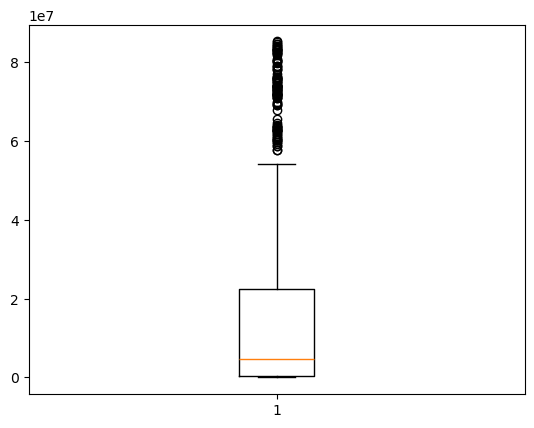

In [36]:
### identify outliers

plt.boxplot(vaccination_daily_df['daily_people_vaccinated'])

In [37]:
## Identify outliers ; IQR method


var_vaccin = vaccination_daily_df['daily_people_vaccinated']
q1 = np.quantile(var_vaccin, 0.25) 
q3 = np.quantile(var_vaccin, 0.75)   
iqr = q3 - q1
outliers_vaccin = var_vaccin[(var_vaccin > (q3 + (iqr * 1.5))) | (var_vaccin < (q1 - (iqr * 1.5)))].tolist()

print(f'Q1= {q1}')
print(f'Q3= {q3}')
print(f'iqr= {iqr}')
print(outliers_vaccin)

Q1= 324828.5
Q3= 22429195.75
iqr= 22104367.25
[70897771.0, 71244066.0, 71732291.0, 71993125.0, 71753642.0, 71755552.0, 73665876.0, 74032946.0, 75023163.0, 75707873.0, 79055077.0, 80470230.0, 80146560.0, 79794944.0, 80720552.0, 82321311.0, 82138443.0, 78902740.0, 78617038.0, 78150873.0, 77086384.0, 74176297.0, 73466296.0, 73082173.0, 72798246.0, 71590562.0, 72024639.0, 73850017.0, 74832820.0, 72709210.0, 71788304.0, 71762351.0, 73051031.0, 73946087.0, 72085920.0, 72620961.0, 73626242.0, 74085852.0, 73899498.0, 71947747.0, 69932034.0, 69515913.0, 69353397.0, 69101392.0, 69041968.0, 70971785.0, 72305993.0, 74633482.0, 76263935.0, 78084831.0, 80238088.0, 82316276.0, 82930755.0, 85100576.0, 84605700.0, 84005273.0, 83810184.0, 83098907.0, 83348732.0, 83138862.0, 81850606.0, 82435590.0, 83608485.0, 84562249.0, 85212333.0, 83980506.0, 83267156.0, 83134048.0, 82423614.0, 80223589.0, 78347396.0, 76167442.0, 75680421.0, 73917939.0, 73551130.0, 75213889.0, 75645191.0, 75829095.0, 76303572.0, 75587

In [38]:
## remove outliers

vaccination_daily_clean_df = vaccination_daily_df[~vaccination_daily_df['daily_people_vaccinated'].isin(outliers_vaccin)]
vaccination_daily_clean_df

,date,daily_people_vaccinated
0,2020-12-02,0.0
1,2020-12-03,4.0
2,2020-12-04,4.0
3,2020-12-05,4.0
4,2020-12-06,4.0
...,...,...
1347,2024-08-10,12.0
1348,2024-08-11,7.0
1349,2024-08-12,7.0
1350,2024-08-13,1.0


####     !!! : it seems we have nested outliers> dont want to change the method and remain with IQR > i accept the dataset as it is


### 2.6.2 Calculate moving average

In [40]:
## Calculate a moving average

## define number of days 
x_days = 7 

## calculate + create a list + add to a new columns

Vaccination_smooth_list= []
daily_smooth = 0

for i in range((x_days), (len(vaccination_daily_clean_df))):

    daily_smooth = vaccination_daily_clean_df['daily_people_vaccinated'].iloc[(i-x_days):i].mean()
    Vaccination_smooth_list.append(daily_smooth)

# Insert the first day manually (since there's no previous day for the first value)
for j in range(0,x_days) :
    Vaccination_smooth_list.insert((j), Vaccination_smooth_list[0])


# Add the daily flow to the DataFrame
vaccination_daily_clean_df['daily_vaccination_smooth'] = Vaccination_smooth_list

# death_daily_clean_df.to_csv('Output/test4.csv')
vaccination_daily_clean_df

C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\2297840506.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_daily_clean_df['daily_vaccination_smooth'] = Vaccination_smooth_list


,date,daily_people_vaccinated,daily_vaccination_smooth
0,2020-12-02,0.0,3.428571
1,2020-12-03,4.0,3.428571
2,2020-12-04,4.0,3.428571
3,2020-12-05,4.0,3.428571
4,2020-12-06,4.0,3.428571
...,...,...,...
1347,2024-08-10,12.0,36.285714
1348,2024-08-11,7.0,31.714286
1349,2024-08-12,7.0,27.000000
1350,2024-08-13,1.0,22.857143


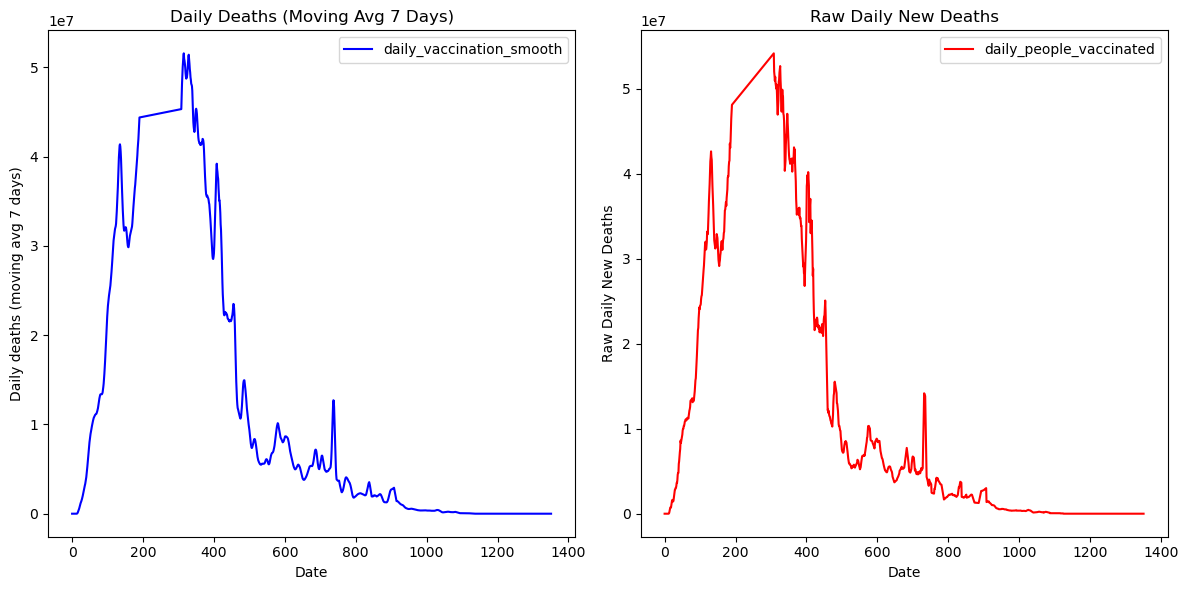

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot - Smoothed daily deaths (7-day moving average)
vaccination_daily_clean_df.plot(kind='line', y="daily_vaccination_smooth", ax=ax1, color='blue')
ax1.set_title('Daily Deaths (Moving Avg 7 Days)')
ax1.set_ylabel('Daily deaths (moving avg 7 days)')
ax1.set_xlabel('Date')

# Second subplot - Raw new deaths
vaccination_daily_clean_df.plot(kind='line', y="daily_people_vaccinated", ax=ax2, color='red')
ax2.set_title('Raw Daily New Deaths')
ax2.set_ylabel('Raw Daily New Deaths')
ax2.set_xlabel('Date')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### (2.7) create a DF with full data covid
    # vacination + deaths + population
    # add coordinate from Coutries DF
    # export to csv

In [44]:
##  merge DF death_country + vaccination_country

death_vaccins_country_df = pd.merge(
                                    deaths_country_df,
                                    vaccination_country_df,
                                    how="inner",
                                    left_on = 'country',
                                    right_on = 'country'
                                    )

death_vaccins_country_df.head()

,country,total_deaths,total_people_vaccinated
0,Afghanistan,7998.0,19133644.0
1,Albania,3605.0,1349457.0
2,Algeria,6881.0,7845452.0
3,Andorra,159.0,57497.0
4,Angola,1937.0,16551300.0


In [45]:
## MERGE death_vaccins_df_clean WITH gdp_pop_df
## create fields to be analysed 

data_covid_country_df= pd.merge(
                            death_vaccins_country_df,
                            pop_df,
                            how='left',
                            left_on=  'country',
                            right_on= "country_name"                            
                            )

# add coordinate + region

data_covid_country_df = pd.merge(data_covid_country_df,
                            countries_df,
                            left_on ='country_ID',
                            right_on ='id',
                            how='left')

data_covid_country_df.head()

,country,total_deaths,total_people_vaccinated,country_ID,country_ID_2,country_name,pop_2023,pop_2022,pop_2021,pop_2020,pop_2019,id,iso2Code,name,region,capitalCity,longitude,latitude
0,Afghanistan,7998.0,19133644.0,AFG,AF,Afghanistan,42239854.0,41128771.0,40099462.0,38972230.0,37769499.0,AFG,AF,Afghanistan,South Asia,Kabul,69.1761,34.5228
1,Albania,3605.0,1349457.0,ALB,AL,Albania,2745972.0,2777689.0,2811666.0,2837849.0,2854191.0,ALB,AL,Albania,Europe & Central Asia,Tirane,19.8172,41.3317
2,Algeria,6881.0,7845452.0,DZA,DZ,Algeria,45606480.0,44903225.0,44177969.0,43451666.0,42705368.0,DZA,DZ,Algeria,Middle East & North Africa,Algiers,3.05097,36.7397
3,Andorra,159.0,57497.0,AND,AD,Andorra,80088.0,79824.0,79034.0,77700.0,76343.0,AND,AD,Andorra,Europe & Central Asia,Andorra la Vella,1.5218,42.5075
4,Angola,1937.0,16551300.0,AGO,AO,Angola,36684202.0,35588987.0,34503774.0,33428486.0,32353588.0,AGO,AO,Angola,Sub-Saharan Africa,Luanda,13.242,-8.81155


In [ ]:
data_covid_country_df.columns

In [46]:
## select needed columns

data_covid_country_df = data_covid_country_df[['country',
                                           'id','iso2Code','region',
                                           'total_deaths', 'total_people_vaccinated',
                                           'pop_2023',
                                           'longitude','latitude'
                                           ]]
data_covid_country_df.head()

,country,id,iso2Code,region,total_deaths,total_people_vaccinated,pop_2023,longitude,latitude
0,Afghanistan,AFG,AF,South Asia,7998.0,19133644.0,42239854.0,69.1761,34.5228
1,Albania,ALB,AL,Europe & Central Asia,3605.0,1349457.0,2745972.0,19.8172,41.3317
2,Algeria,DZA,DZ,Middle East & North Africa,6881.0,7845452.0,45606480.0,3.05097,36.7397
3,Andorra,AND,AD,Europe & Central Asia,159.0,57497.0,80088.0,1.5218,42.5075
4,Angola,AGO,AO,Sub-Saharan Africa,1937.0,16551300.0,36684202.0,13.242,-8.81155


In [47]:
## Export to CSV file 

data_covid_country_path = 'Output/Q4_output_covid_deaths_vaccin_by_country.csv'
data_covid_country_df.to_csv(data_covid_country_path)

# (3) Analysis vaccination vs deaths

## 3.1) analysis of the daily evolution

In [48]:
## Create df daily evol deaths + vaccination 
 
data_daily_df = pd.merge(
                        deaths_daily_clean_df,
                        vaccination_daily_clean_df,
                        how='inner',
                        on = 'date')

# select columns + replace NAN values
data_daily_df = data_daily_df[['date','daily_deaths_smooth','daily_vaccination_smooth']]
                              
data_daily_df = data_daily_df.fillna({
                                    'daily_deaths_smooth':0,
                                    'daily_vaccination_smooth' : 0
                                    })

data_daily_df

,date,daily_deaths_smooth,daily_vaccination_smooth
0,2020-12-02,8701.000000,3.428571
1,2020-12-03,8789.571429,3.428571
2,2020-12-04,8961.571429,3.428571
3,2020-12-05,9142.428571,3.428571
4,2020-12-07,9209.857143,3.428571
...,...,...,...
1205,2024-08-10,196.428571,36.285714
1206,2024-08-11,196.857143,31.714286
1207,2024-08-12,195.714286,27.000000
1208,2024-08-13,190.142857,22.857143


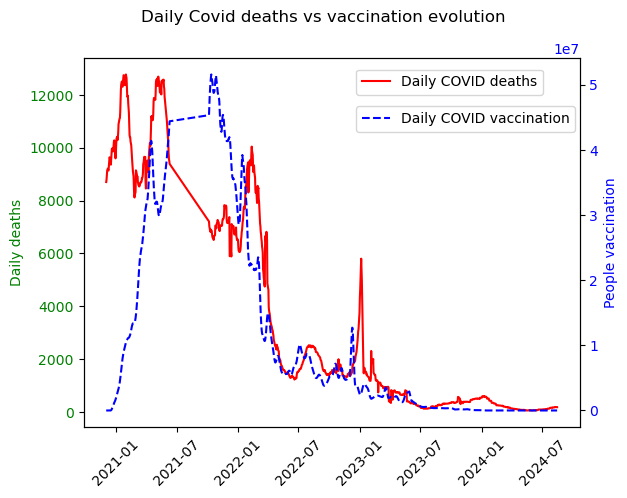

In [56]:
## Create a plot with 2 scales

x = data_daily_df['date']
y1 = data_daily_df['daily_deaths_smooth']
y2 = data_daily_df['daily_vaccination_smooth']

# Create the first plot with the first y-axis
fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'r-', label='Daily COVID deaths')  # Plot y1 with green color
# ax1.set_xlabel('Date')
ax1.set_ylabel('Daily deaths', color='g')
ax1.tick_params(axis='x', rotation = 45)
ax1.tick_params(axis='y', labelcolor='g')  # Set y-axis tick labels color

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, y2, 'b--', label='Daily COVID vaccination')  # Plot y2 with blue dashed line
ax2.set_ylabel('People vaccination', color='b')
ax2.tick_params(axis='y', labelcolor='b')  # Set y-axis tick labels color

# Optional: Add title and legends
fig.suptitle('Daily Covid deaths vs vaccination evolution')
ax1.legend(loc=(0.55,0.9))
ax2.legend(loc=(0.55,0.8))

plt.savefig("Output/Q4_evolution_vaccins_deaths_daily_2021_2024.png")
plt.show()

 The r^value is : 0.724


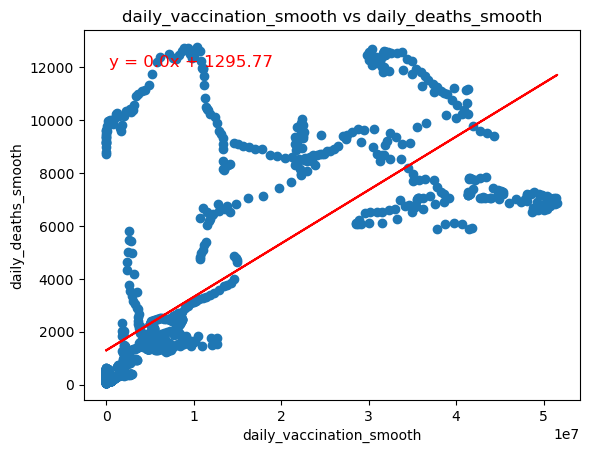

In [57]:
# Correlation between vaccination and deaths
# Build scatter plot for vaccination vs deaths on daily basis

regression_plot(data_daily_df,'daily_vaccination_smooth', 'daily_deaths_smooth')


## 3.2 Analysis by country

In [58]:
##  merge DF death + vaccination

death_vaccins_country_df = pd.merge(
                                    deaths_country_df,
                                    vaccination_country_df,
                                    how="inner",
                                    left_on = 'country',
                                    right_on = 'country'
                                    )

death_vaccins_country_df.head()

,country,total_deaths,total_people_vaccinated
0,Afghanistan,7998.0,19133644.0
1,Albania,3605.0,1349457.0
2,Algeria,6881.0,7845452.0
3,Andorra,159.0,57497.0
4,Angola,1937.0,16551300.0


In [59]:
data_country_df = data_covid_country_df.copy()
data_country_df.dtypes 

country                     object
id                          object
iso2Code                    object
region                      object
total_deaths               Float64
total_people_vaccinated    float64
pop_2023                   float64
longitude                   object
latitude                    object
dtype: object

In [60]:
## calculate vaccination %

data_country_df['vaccination%'] = data_country_df['total_people_vaccinated']*100/data_country_df['pop_2023']

## calculate deaths/population %

data_country_df['death%'] = data_country_df['total_deaths']*100/data_country_df['pop_2023']

## calculate growth per capita % (if gdp2023 = Nan, replace with 2022 data)
# data_country['Grwth'] = np.where(data1['GDPcap_2023'].notna(),
#     (data_country['GDPcap_2023']-data_country['GDPcap_2019'])*100/(data_country['GDPcap_2019']*4),
#     (data_country['GDPcap_2022']-data_country['GDPcap_2019'])*100/(data_country['GDPcap_2019']*3))


## drop empty cells / rows
data_country_df = data_country_df.dropna(how='any')

data_country_df.head()

,country,id,iso2Code,region,total_deaths,total_people_vaccinated,pop_2023,longitude,latitude,vaccination%,death%
0,Afghanistan,AFG,AF,South Asia,7998.0,19133644.0,42239854.0,69.1761,34.5228,45.297609,0.018935
1,Albania,ALB,AL,Europe & Central Asia,3605.0,1349457.0,2745972.0,19.8172,41.3317,49.143145,0.131283
2,Algeria,DZA,DZ,Middle East & North Africa,6881.0,7845452.0,45606480.0,3.05097,36.7397,17.202494,0.015088
3,Andorra,AND,AD,Europe & Central Asia,159.0,57497.0,80088.0,1.5218,42.5075,71.792278,0.198532
4,Angola,AGO,AO,Sub-Saharan Africa,1937.0,16551300.0,36684202.0,13.242,-8.81155,45.118332,0.00528


C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\4159803020.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data1_dict.values(),labels=data1_dict.keys())


<function matplotlib.pyplot.show(close=None, block=None)>

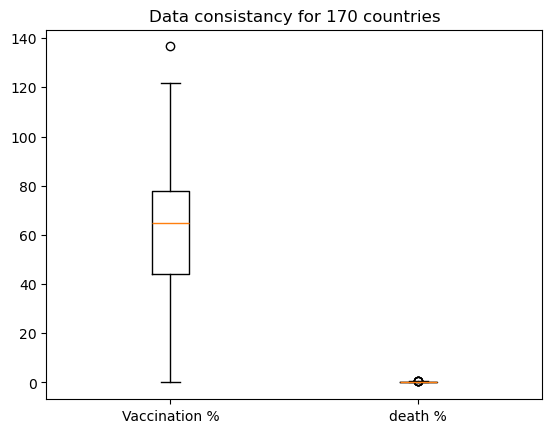

In [61]:
## identify outlayers

lenth = len(data_country_df['country'])

data1_dict = {
    'Vaccination %': data_country_df['vaccination%'],
    'death %' : data_country_df['death%'],
    }

plt.boxplot(data1_dict.values(),labels=data1_dict.keys())
plt.title(f'Data consistancy for {lenth} countries')

# plt.savefig("Output/boxplots.png")
plt.show

C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\3334881574.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


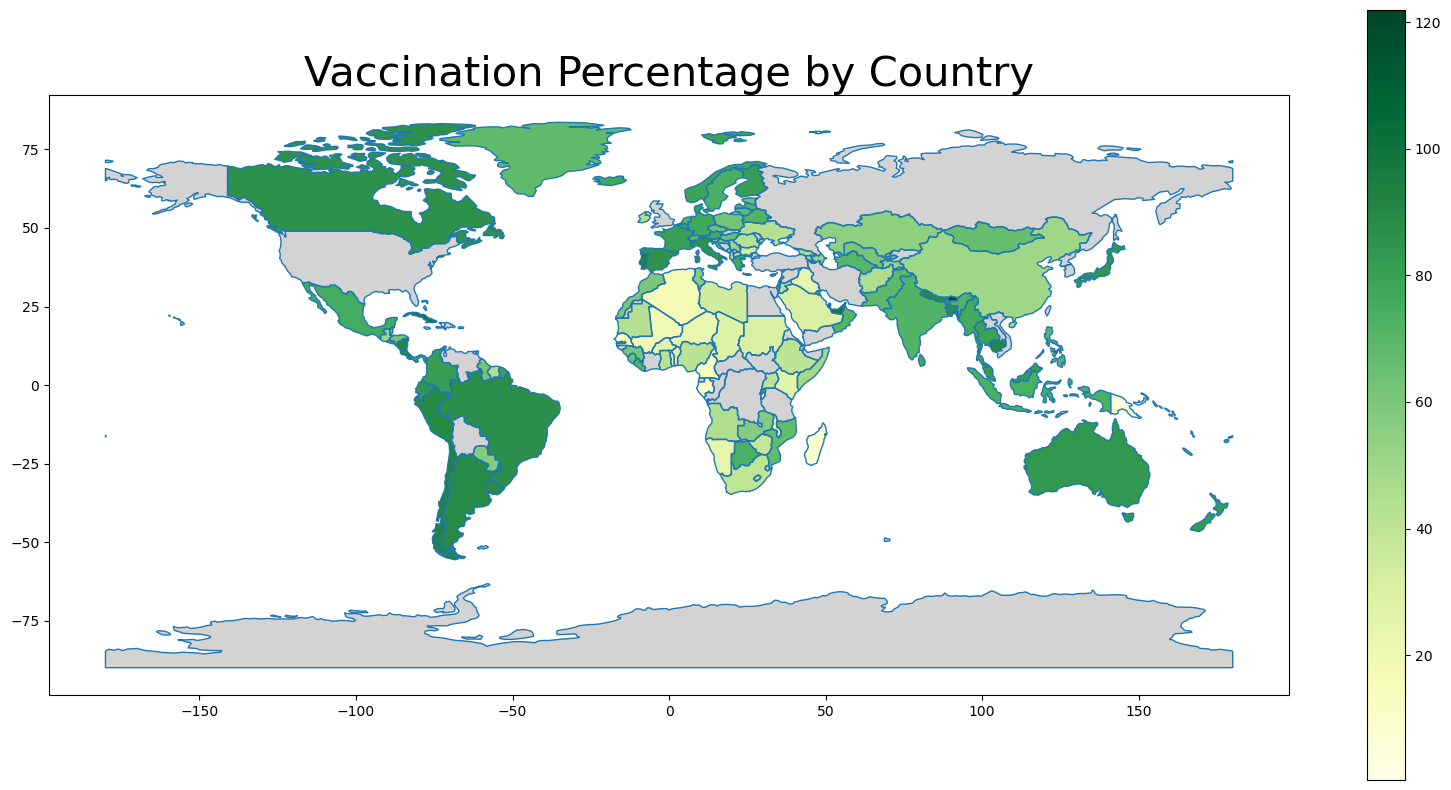

In [62]:
## Create a world map with Vaccination %
#  
# Sample data: replace actual DataFrame
data = pd.DataFrame({
    'country_name': data_country_df['country'],  # Replace with your country names
    'vaccination': data_country_df['vaccination%']  # Replace with your actual data
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="country_name")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='vaccination', ax=ax, legend=True,
           cmap='YlGn', missing_kwds={"color": "lightgrey"})

plt.title('Vaccination Percentage by Country', fontsize = 30)
plt.savefig("Output/Q4_Vaccination%_worldwide.png")

plt.show()

C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\3320177160.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


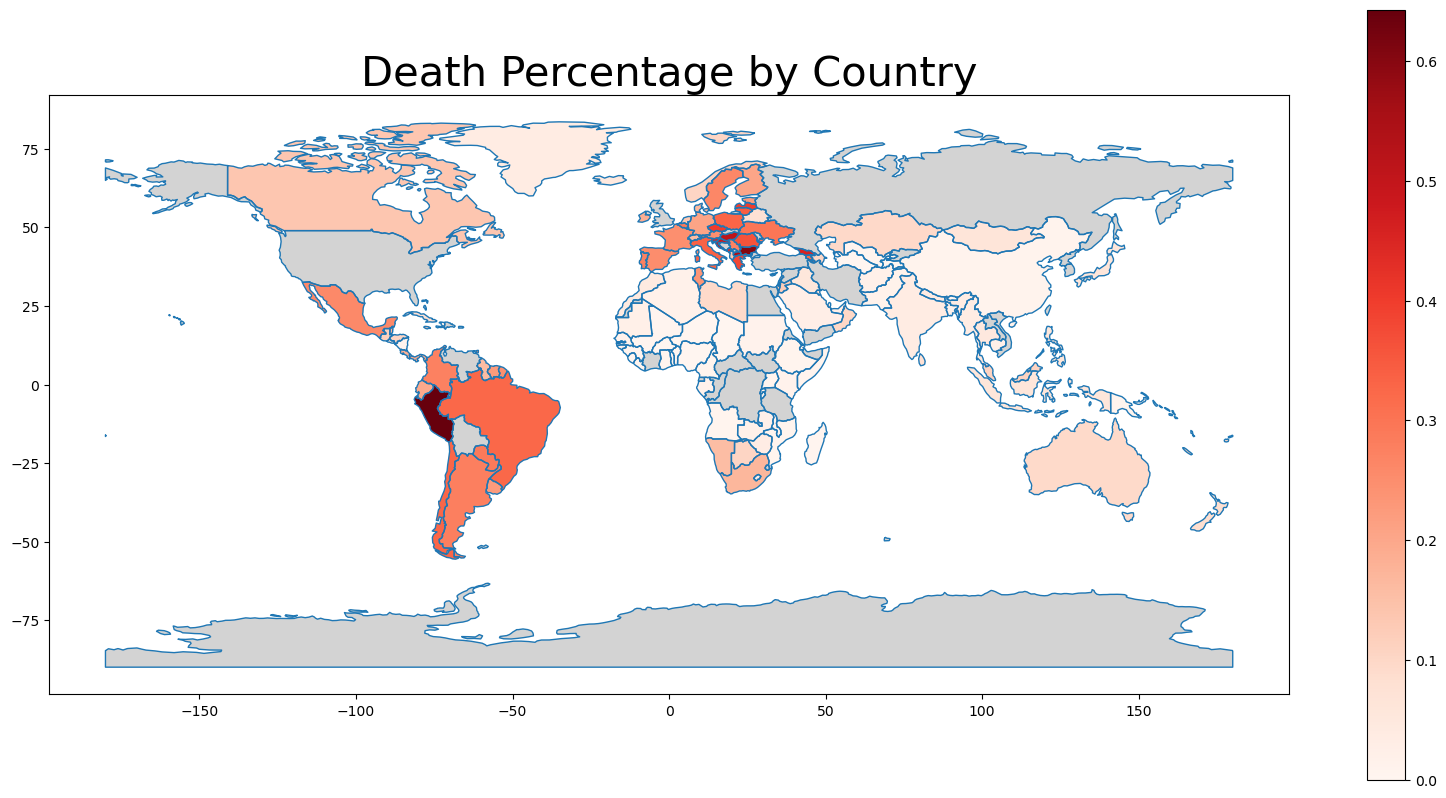

In [63]:
## Create a world map with death %
#  
# Sample data: replace this with your actual DataFrame
data = pd.DataFrame({
    'country_name': data_country_df['country'],  # Replace with your country names
    'death_percentage': data_country_df['death%']  # Replace with your actual data
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="country_name")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='death_percentage', ax=ax, legend=True,
           cmap='Reds', missing_kwds={"color": "lightgrey"})

plt.title('Death Percentage by Country', fontsize = 30)
plt.savefig("Output/Q4_death%_worlwide.png")

plt.show()

 The r^value is : 0.189


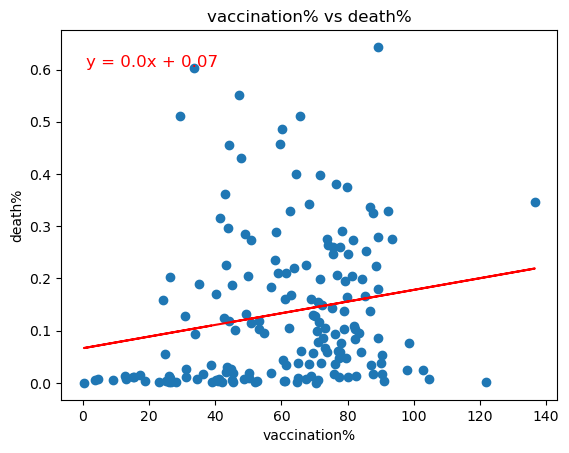

In [64]:
# Build scatter plot for vaccination vs deaths

regression_plot(data_country_df,'vaccination%', 'death%')

## 3.3) Analyse by Region

In [65]:
data_country_df = data_covid_country_df.copy()
data_country_df.dtypes 

data_regions_df = data_country_df.groupby(['region']).agg({
                        'total_deaths' : 'sum',
                        'total_people_vaccinated': 'sum',
                        'pop_2023': 'sum',
                        })

## calculate vaccination % /population %

data_regions_df['vaccination%'] = data_regions_df['total_people_vaccinated']*100/data_regions_df['pop_2023']

# calculate deaths/population %

data_regions_df['deaths%'] = data_regions_df['total_deaths']*100/data_regions_df['pop_2023']

# # ## calculate growth per capita % (if gdp2023 = Nan, replace with 2022 data)

# data_regions_df['Grwth'] = np.where(data_regions_df['GDPcap_2023'].notna(),
#     (data_regions_df['GDPcap_2023']-data_regions_df['GDPcap_2019'])*100/(data_regions_df['GDPcap_2019']*4),
#     (data_regions_df['GDPcap_2022']-data_regions_df['GDPcap_2019'])*100/(data_regions_df['GDPcap_2019']*3)
#     )

# # ## drop empty cells / rows
# data_regions_df = data_regions_df.dropna(how='any')

# data_regions_clean_df = data_regions_df.drop(columns = {'TOTAL_VACCINATIONS', 'Cumulative_deaths', 'GDPcap_2023', 'GDPcap_2022','GDPcap_2019', 'pop_2023'})

# data_regions_clean_df = data_regions_clean_df.sort_values('death_%', ascending=False)

data_regions_df = data_regions_df.reset_index()

data_regions_df

,region,total_deaths,total_people_vaccinated,pop_2023,vaccination%,deaths%
0,East Asia & Pacific,557223.0,1.274792e+09,2.162366e+09,58.953577,0.025769
1,Europe & Central Asia,1486978.0,4.250110e+08,6.094282e+08,69.739311,0.243996
2,Latin America & Caribbean,1739911.0,4.987788e+08,6.186522e+08,80.623459,0.281242
3,Middle East & North Africa,144728.0,9.825642e+07,2.360553e+08,41.624316,0.061311
4,North America,55447.0,3.478870e+07,4.016125e+07,86.622563,0.138061
5,South Asia,631069.0,1.410502e+09,1.938550e+09,72.760680,0.032554
6,Sub-Saharan Africa,169515.0,3.864474e+08,1.030096e+09,37.515657,0.016456


C:\Users\nazim\AppData\Local\Temp\ipykernel_46484\3330835086.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(categories))  # Get a color map


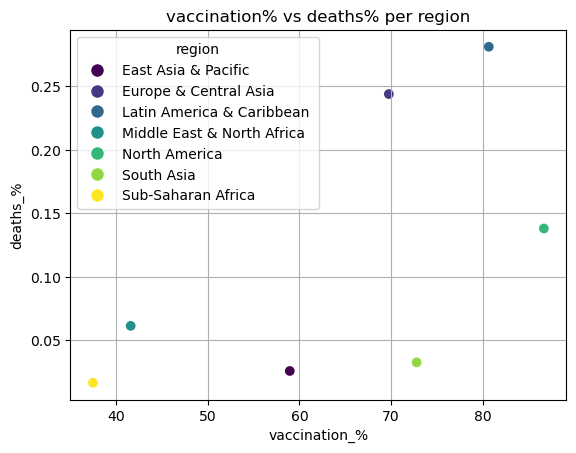

In [66]:

# Create a dictionary to map each unique category in 'col1' to a color
categories = data_regions_df['region'].unique()
colors = plt.cm.get_cmap('viridis', len(categories))  # Get a color map

# Create a color mapping for each category
color_mapping = {category: colors(i) for i, category in enumerate(categories)}

# Assign colors based on the 'region' value for each row
category_colors = data_regions_df['region'].map(color_mapping)

# Create the scatter plot with colored points
plt.scatter(data_regions_df['vaccination%'], 
            data_regions_df['deaths%'], 
            c=category_colors)

plt.xlabel('vaccination_%')
plt.ylabel('deaths_%')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[category], markersize=10, label=category) 
           for category in categories]

plt.legend(handles=handles, title="region")

plt.title('vaccination% vs deaths% per region')
plt.grid()

plt.savefig("Output/Q4_vaccins_vs_deaths_per_region.png")
plt.show()
